### Code flow control block

In [1]:
import glob
import numpy as np

do_feat_extract = False
do_plot_features = False
recreate_scaler = False
rescale_and_slipt_features = False
optimize_params = False
do_train = False
calc_accuracy = False
enable_norm = False

train_test_spilt = 0.2
spatial_div = 255.

feat_extr = \
    {
        'color_space': 'YUV',
        'hist_bins': 32,
        'spatial_size': (8, 8),
        'orient': 11,
        'pix_per_cell': 16,
        'cell_per_block': 2,
        'hog_channel': 'ALL',
        'spatial_feat': False,
        'hist_feat': False,
        'hist_color_space': 'HLS',
        'hist_color_chn': 0,
        'hog_feat': True,
    }


#picke_postfix = 'all_x32'
#picke_postfix = '1_x32'
#picke_postfix = '1314_x8'
picke_postfix = 'full_x32'
#ve_images = glob.glob("learn/vehicles/selection/*.png")
#nv_images = glob.glob("learn/non-vehicles/selection/*.png")
#ve_images = glob.glob("learn/vehicles/selection/1*.png")
#nv_images = glob.glob("learn/non-vehicles/selection/image1*.png")
#ve_images = glob.glob("learn/vehicles/selection/13*.png")
#nv_images = glob.glob("learn/non-vehicles/selection/image13*.png")
#ve_images = glob.glob("learn/vehicles/selection/1[34]*.png")
#nv_images = glob.glob("learn/non-vehicles/selection/image1[34]*.png")

ve_images1 = glob.glob("learn/vehicles/GTI_Far/*.png")
ve_images2 = glob.glob("learn/vehicles/GTI_Left/*.png")
ve_images3 = glob.glob("learn/vehicles/GTI_MiddleClose/*.png")
ve_images4 = glob.glob("learn/vehicles/GTI_Right/*.png")
ve_images5 = glob.glob("learn/vehicles/KITTI_extracted/*.png")
ve_images  = np.concatenate((ve_images1, ve_images2, ve_images3, ve_images4, ve_images5))
nv_images1 = glob.glob("learn/non-vehicles/GTI/*.png")
nv_images2 = glob.glob("learn/non-vehicles/Extras/*.png")
nv_images  = np.concatenate((nv_images1, nv_images2))

### Helper functions

In [2]:
import matplotlib.image as mpimg
from math import floor
import cv2
from skimage.feature import hog
import time
from pickle import dump as pkdump
from pickle import load as pkload
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
                                  #block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
                       #block_norm='L2-Hys')
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=16, bins_range=(0, 16), hist_color_chn=0):
    # Compute the histogram of the color channels separately
    #channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    #channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    #channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    hist_features = np.concatenate((np.histogram(img[:,:,hist_color_chn], bins=nbins, range=bins_range)))
    #print ('hist_features=', hist_features)
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=16,  hist_color_space='HLS', hist_color_chn=0,
                        orient=9, pix_per_cell=8, cell_per_block=6, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        if image.shape != (64,64,3): image = cv2.resize(image, (64, 64))
        file_features = []

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features / spatial_div)
        if hist_feat == True:
            if hist_color_space != 'RGB':
                if hist_color_space == 'HSV':
                    feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif hist_color_space == 'LUV':
                    feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif hist_color_space == 'HLS':
                    feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif hist_color_space == 'YUV':
                    feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif hist_color_space == 'YCrCb':
                    feature_image_hist = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image_hist = np.copy(image)
            # Apply color_hist()
            hist_features = color_hist(feature_image_hist, nbins=hist_bins, hist_color_chn=hist_color_chn)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=False))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_bbox_hog(img, ystart, ystop, scale, overlap, clf, orient, pix_per_cell, cell_per_block):
    
    yovr = floor(64*scale*(1-overlap[1]))
    
    bboxes = []
    
    for ystart_i in (ystart, ystart+yovr):
        
        #print (ystart_i, ystop, scale, orient, pix_per_cell, cell_per_block) # FIXME

        # not drawing here
        imgcpy = np.copy(img)
        imgcpy = imgcpy.astype(np.float32)/255
        
        img_tosearch = imgcpy[ystart_i:ystop,:,:]
        
        # I'm using cv2.imread and YUV only
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # using all channels
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)  + 1
        nyblocks = (ch1.shape[0] // pix_per_cell)  + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch

                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
                if clf.predict(hog_features) == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bboxes.append([[xbox_left, ytop_draw + ystart_i], [xbox_left + win_draw, ytop_draw + win_draw+ystart_i]])
                    #print (bboxes[-1])
    
    return bboxes
    

### Loading images, creating feature data

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

ve_featvec = None
nv_featvec = None
if do_feat_extract:

    t1 = time.time()
    print ('Extracting Sp+HOG features for', len(ve_images),  'VE images ...')

    imgs = []
    ve_featvec = []
    for file in ve_images:
        # Read in each one by one
        #imgs.append(cv2.imread(file))
        img = cv2.cvtColor(mpimg.imread(file), cv2.COLOR_RGB2YUV)
        hog0 = get_hog_features(img[:,:,0], feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'], feature_vec=False)
        hog1 = get_hog_features(img[:,:,1], feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'], feature_vec=False)
        hog2 = get_hog_features(img[:,:,2], feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'], feature_vec=False)
        hog_features = np.hstack((hog0.ravel(), hog1.ravel(), hog2.ravel()))
        ve_featvec.append(hog_features)

    #ve_featvec = extract_features(imgs,
    #    color_space=feat_extr['color_space'], hist_bins=feat_extr['hist_bins'], spatial_size=feat_extr['spatial_size'], orient=feat_extr['orient'],
    #    pix_per_cell=feat_extr['pix_per_cell'], cell_per_block=feat_extr['cell_per_block'], hog_channel=feat_extr['hog_channel'],
    #    spatial_feat=feat_extr['spatial_feat'], hist_feat=feat_extr['hist_feat'], hist_color_space=feat_extr['hist_color_space'], hist_color_chn=feat_extr['hist_color_chn'],
    #    hog_feat=feat_extr['hog_feat'])    

    t2 = time.time()
    print ("Done in", int(t2-t1), "secs.")

    print ('Extracting Sp+HOG features for', len(nv_images),  'NV images ...')
    imgs = []
    nv_featvec = []
    for file in nv_images:
        img = cv2.cvtColor(mpimg.imread(file), cv2.COLOR_RGB2YUV)
        hog0 = get_hog_features(img[:,:,0], feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'], feature_vec=False)
        hog1 = get_hog_features(img[:,:,1], feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'], feature_vec=False)
        hog2 = get_hog_features(img[:,:,2], feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'], feature_vec=False)
        hog_features = np.hstack((hog0.ravel(), hog1.ravel(), hog2.ravel()))
        nv_featvec.append(hog_features)   

    t3 = time.time()
    print ("Done in", int(t3-t2), "secs.")

    #print ("Checking and converting NaN values ...")
    #if np.any(np.isnan(ve_featvec)):
    #    ve_featvec = np.nan_to_num(ve_featvec)
    #if np.any(np.isnan(nv_featvec)):
    #    nv_featvec = np.nan_to_num(nv_featvec)
    #print ("Done.")    
    
    pfname = 'fvec_' + picke_postfix + '.p'
    print ("Storing pickled feature data into", pfname, "...")
    feat_p = { 've': ve_featvec, 'nv': nv_featvec }
    pkdump(feat_p, open(pfname, 'wb'))
    t4 = time.time()
    print ("Done in", int(t4-t3), "secs.")
    
else:
    t1 = time.time()
    
    pfname = 'fvec_' + picke_postfix + '.p'
    print ("Loading pickled feature data from", pfname, "...")
    feat_p = pkload(open(pfname, 'rb'))
    ve_featvec = feat_p['ve']
    nv_featvec = feat_p['nv']
    print (len(ve_featvec), 'Sp+HOG features loaded for VE images.')
    print (len(nv_featvec), 'Sp+HOG features loaded for NV images.')
    t2 = time.time()
    print ("Done in", int(t2-t1), "secs.")

print ('Feature vector length:', len(ve_featvec[0]))
#for fname in images:
#    image = mpimg.imread(fname)
#    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#    hist_features = color_hist(feature_image, nbins=32)
#    print (hist_features)


#v_featvec_arr = np.array(v_featvec).reshape(-1,4368)

#print (v_featvec_arr.shape)
#print (np.argmax(v_featvec_arr))
#print (np.max(nv_featvec), np.min(nv_featvec))

#print (np.any(np.isnan(v_featvec)), np.all(np.isfinite(v_featvec)))


if do_plot_features:
    i = 0
    for feat in ve_featvec:
        plt.figure()
        plt.plot(feat)
        #print (np.max(feat), np.min(feat))
        i += 1
        if i >= 10: break
    i = 0
    for feat in nv_featvec:
        plt.figure()
        plt.plot(feat)
        #print (np.max(feat), np.min(feat))
        i += 1
        if i >= 10: break
    plt.show

Loading pickled feature data from fvec_full_x32.p ...
8792 Sp+HOG features loaded for VE images.
8968 Sp+HOG features loaded for NV images.
Done in 0 secs.
Feature vector length: 1188


### Creating scaler, scaling data, splitting data

In [10]:
from sklearn.utils import shuffle

#nv_featvec_stack = np.vstack(nv_featvec).astype(np.float64)
#ve_featvec_stack = np.vstack(ve_featvec).astype(np.float64)
# Create an array stack, NOTE: StandardScaler() expects np.float64

full_featvec_stack = None
#full_featvec_stack_test = None
feat_scaler = None

if enable_norm:
    if recreate_scaler:
        t1 = time.time()
        print('Fitting scaler...')
        #feature_list = [feature_vec1, feature_vec2, ...]

        full_featvec_stack = np.vstack((np.vstack(ve_featvec).astype(np.float64), np.vstack(nv_featvec).astype(np.float64)))
        # Fit a per-column scaler
        feat_scaler = StandardScaler().fit(full_featvec_stack)

        t2 = time.time()
        print ("Done in", int(t2-t1), "secs.")

        pfname = 'scalefeat_' + picke_postfix + '.p'
        print ("Storing pickled scaler data into", pfname, "...")
        scalefeat_p = { 'feat_scaler': feat_scaler }
        pkdump(scalefeat_p, open(pfname, 'wb'))
        print ("Done.")
    else:
        pfname = 'scalefeat_' + picke_postfix + '.p'
        print ("Loading pickled scaler data from", pfname, "...")
        scalefeat_p = pkload(open(pfname, 'rb'))
        feat_scaler = scalefeat_p['feat_scaler']
        print ("Done.")
else:
    full_featvec_stack = np.vstack((ve_featvec, nv_featvec)).astype(np.float64) 


    
print(np.max(full_featvec_stack), np.min(full_featvec_stack))
print(np.sum(full_featvec_stack))
    
(X_train, X_test, y_train, y_test) = (None, None, None, None)

if rescale_and_slipt_features:
    t1 = time.time()
    print('Scaling features...')
    # Apply the scaler to X
    #nv_featvec_scaled = feat_scaler.transform(nv_featvec_stack)
    #ve_featvec_scaled = feat_scaler.transform(ve_featvec_stack)

    if full_featvec_stack is None:
        full_featvec_stack = np.vstack((np.vstack(ve_featvec).astype(np.float64), np.vstack(nv_featvec).astype(np.float64)))
    
    X = None
    if enable_norm:
        X = feat_scaler.transform(full_featvec_stack)
    else:
        X = full_featvec_stack

    t2 = time.time()
    print ("Done in", int(t2-t1), "secs.")

    y = np.hstack((np.ones(len(ve_featvec)), np.zeros(len(nv_featvec))))
    
    #print (X.shape, y.shape)

    print('Splitting up features...')
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_spilt, random_state=rand_state)
    print ('Done.')
    
    pfname = 'traintest_' + picke_postfix + '.p'
    print ("Storing pickled training/test data into", pfname, "...")
    traintest_p = { 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test }
    pkdump(traintest_p, open(pfname, 'wb'))
    print ("Done.")
else:
    pfname = 'traintest_' + picke_postfix + '.p'
    print ("Loading pickled scaled training/test data from", pfname, "...")
    traintest_p = pkload(open(pfname, 'rb'))

    X_train = traintest_p['X_train']
    X_test  = traintest_p['X_test']
    y_train = traintest_p['y_train']
    y_test  = traintest_p['y_test']
    print ("Done.")

print (len(X_train), 'Sp+HOG features in VE+NV train')
print (len(X_test),  'Sp+HOG features in VE+NV test')
print (len(y_train), 'Sp+HOG labels in VE+NV train')
print (len(y_test),  'Sp+HOG labels in VE+NV test')

0.950775913537 0.0
479213.258618
Loading pickled scaled training/test data from traintest_full_x32.p ...
Done.
14208 Sp+HOG features in VE+NV train
3552 Sp+HOG features in VE+NV test
14208 Sp+HOG labels in VE+NV train
3552 Sp+HOG labels in VE+NV test


### Parameter optimization

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.svm import SVC

if optimize_params:
    t1 = time.time()
    print('Optimizing SVM params...')

    #parameters = { 'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': [1, 4, 7], 'gamma': [1, 4, 7] }
    parameters = { 'kernel': ('linear', 'rbf', 'poly'), 'C': [1, 4, 7, 10, 13, 16] } # gamma=’auto’
    #parameters = { 'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': [1], 'gamma': [1] }
    svr = SVC(degree=3) # degree of poly
    #clf = RandomizedSearchCV(svr, parameters, verbose=True, n_iter=8)
    clf = GridSearchCV(svr, parameters, verbose=True, n_jobs=4)

    #full_featvec_stack = np.vstack((np.vstack(nv_featvec), np.vstack(ve_featvec)))
    #target = np.hstack((np.ones(len(ve_featvec)), np.zeros(len(nv_featvec))))
    #clf.fit(full_featvec_stack, target)

    clf.fit(X_train, y_train)

    t2 = time.time()
    print ("Done in", int(t2-t1), "secs.")
    
    #print (clf.cv_results_['params'])
    #print (clf.cv_results_['mean_train_score'])
    #print (clf.cv_results_['mean_test_score'])
    res_arr = []
    for res in zip(clf.cv_results_['params'], clf.cv_results_['mean_train_score'], clf.cv_results_['mean_test_score']):
        res_arr.append(res)
    
    res_sorted = sorted(res_arr, key=lambda res_arr: res_arr[2], reverse=True)
    for res in res_sorted:
        print ("%-50s |   %.2f%% / %.2f%%" % (res[0], (res[1]*100), (res[2]*100)))

else:
    print ("Parameter optimization was switched off.")


Parameter optimization was switched off.


### Training/loading SVM

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

clf = None

if do_train:
    print('Training SVM on', len(X_train), 'features ...')
    t1 = time.time()
    clf = SVC(kernel='rbf', C=10, gamma='auto') # 99.97% / 96.34%
    #clf = SVC(kernel='linear', C=1, gamma='auto') # 100.00% / 95.69%
    #clf = LinearSVC() # 99.97% / 96.34%
    clf.fit(X_train, y_train)
    t2 = time.time()
    print ("Done in", int(t2-t1), "secs.")

    pfname = 'svm_' + picke_postfix + '.p'
    print ("Storing pickled SVM data into", pfname, "...")
    svm_p = { 'clf': clf }
    pkdump(svm_p, open(pfname, 'wb'))
    print ("Done.")
else:
    pfname = 'svm_full_x32-rbf.p'
    #pfname = 'svm_' + picke_postfix + '.p'
    print ("Loading pickled SVM data from", pfname, "...")
    svm_p = pkload(open(pfname, 'rb'))
    clf = svm_p['clf']
    print ("Done.")

if calc_accuracy:
    print('Calculating accuracy on', len(X_test), 'features ...')
    t1 = time.time()    
    pred = clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    t2 = time.time()
    print ("Done in", int(t2-t1), "secs.")
    print ('Accuracy: %.2f%%' % (acc*100))

Loading pickled SVM data from svm_full_x32-rbf.p ...
Done.


### Creating window templates

In [4]:
#import numpy as np
#import cv2
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import random


pfname = 'svm.p'
svm_p = pkload(open(pfname, 'rb'))
clf = svm_p['clf']
print ("Done.")

shp = (720,1280)
regions = \
    [   # x_start_stop, y_start_stop, xy_window, xy_overlap, color
        #[ (515,  960), (395, 485), ( 48,  48), (0.4, 0.4), (251, 89, 114) ], # upper 1/4
        #[ (515, None), (380, 525), ( 96,  96), (0.6, 0.6), (253, 87, 253) ], # upper 1/4-2/4
        #[ (410, None), (380, 650), (160, 160), (0.7, 0.7), (174, 88, 252) ], # upper 2/4-3/4
        #[ (380, None), (380, 700), (240, 240), (0.8, 0.8), ( 87, 91, 253) ], # upper 3/4-4/4
        #[ (545,  None), (395, 480), ( 64,  64), (0.5, 0.75), (251, 89, 114) ], # upper 1/4
        #[ (545, None), (395, 525), ( 96,  96), (0.5, 0.6667), (253, 87, 253) ], # upper 1/4-2/4
        #[ (545, None), (395, 555), (128, 128), (0.5, 0.75), (174, 88, 252) ], # upper 2/4-3/4
        ##[ (405, None), (395, 700), (192, 192), (0.5, 0.6667), ( 87, 91, 253) ], # upper 3/4-4/4
        #[ (405, None), (395, 700), (224, 224), (0.5, 0.714), ( 87, 91, 253) ], # upper 3/4-4/4
        
        [ (None, None), (400, 705), (224, 224), (0.5, 0.71), ( 87, 91, 253) ], # upper 3/4-4/4        
        [ (None, None), (400, 561), (128, 128), (0.5, 0.75), (174, 88, 252) ], # upper 2/4-3/4
        [ (None, None), (400, 529), ( 96,  96), (0.5, 0.66), (253, 87, 253) ], # upper 1/4-2/4
        [ (None, None), (400, 485), ( 64,  64), (0.5, 0.75), (251, 89, 114) ], # upper 1/4
    ]    
    

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(shp, x_start_stop=(None, None), y_start_stop=(None, None),
    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start_stop = list(x_start_stop)
    y_start_stop = list(y_start_stop)
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = shp[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = shp[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

print ("Creating window templates:")
n = 0
windows = []
for reg in regions:
    wnd = slide_window(shp, x_start_stop=reg[0], y_start_stop=reg[1],
        xy_window=reg[2], xy_overlap=reg[3])
    windows.append(wnd)
    print ("  %3dx%3d - %dpcs" % (reg[2][0], reg[2][1], len(wnd)))

windows = np.concatenate(windows)


Done.
Creating window templates:
  224x224 - 20pcs
  128x128 - 38pcs
   96x 96 - 50pcs
   64x 64 - 78pcs


In [5]:
from collections import deque

class BoxMover:
    def __init__(self):
        self.last_boxes = deque(maxlen=12)
    
    def addBox(self, box):
        self.last_boxes.append(box)
    
    def addHistToHeatMap(self, img):
        heatmap = np.zeros_like(img[:,:,0].astype(np.uint8))
        for bbox in self.last_boxes:
            heatmap = get_heat(heatmap, bbox)
        return heatmap
    
    def processImage(self, img):
        
        bboxes = []
        for reg in regions:
            bbox = find_bbox_hog(img, reg[1][0], reg[1][1], reg[2][1]/64, reg[3], clf, feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'])
            bboxes = bboxes + bbox

        heatmap = get_heat(np.zeros_like(img[:,:,0].astype(np.uint8)), bboxes)
        
        heatmap = apply_threshold(heatmap, 1) # remove artifacts
        labels = get_labels(heatmap)
        bboxes = get_labeled_bboxes(labels)
        self.addBox(bboxes)
        heatmap = self.addHistToHeatMap(img)
        apply_threshold(heatmap, 3)
        labels = get_labels(heatmap)
        return draw_labeled_bboxes(img, labels)


In [6]:
from scipy.ndimage.measurements import label

image_fnames = \
    [
        'examples/cap_project_video_00_00_01_01.jpg',
        'examples/cap_project_video_00_00_10_02.jpg',
        'examples/cap_project_video_00_00_16_03.jpg',
        'examples/cap_project_video_00_00_25_04.jpg',
        'examples/cap_project_video_00_00_29_05.jpg',
        'examples/cap_project_video_00_00_37_06.jpg',
        'examples/cap_project_video_00_00_44_07.jpg',
        'examples/cap_project_video_00_00_48_08.jpg',
    ]

image_fnames = glob.glob('test/*.jpg')
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        #print (bbox)
        # Draw a rectangle given bbox coordinates
        color_rnd=(random.randrange(0, 256, 1), random.randrange(0, 256, 1), random.randrange(0, 256, 1))
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color_rnd, thick)
        # Return the image copy with boxes drawn
    return imcopy
    
def get_img_parts(img, windows):
    imgs = []
    for wnd in windows:
        # (startx, starty), (endx, endy)
        imgs.append(img[wnd[0][1]:wnd[1][1], wnd[0][0]:wnd[1][0]])
    
    return imgs


def get_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print (heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]].shape)
        #heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], :] += np.array([70, 40, 10], dtype=heatmap.dtype)
        #print ("heating range", str(box[0][1]) + ":" + str(box[1][1]) + " -> " + str(box[0][0]) + ":" + str(box[1][0])) 
        #heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0], :] += np.array([70, 40, 10], dtype=heatmap.dtype)
        if len(box) > 0:
            if len(box) == 1:
                heatmap[box[0][0][1]:box[0][1][1], box[0][0][0]:box[0][1][0]] += 1
            elif len(box) == 2:
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
                

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def get_labels(heatmap):
    return label(heatmap)

def get_labeled_bboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
    return bboxes

def draw_labeled_bboxes(img, labels):
    bboxes = get_labeled_bboxes(labels)
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars_1(img):
    bboxes = []
    for reg in regions:
        bbox = find_bbox_hog(img, reg[1][0], reg[1][1], reg[2][1]/64, reg[3], clf, feat_extr['orient'], feat_extr['pix_per_cell'], feat_extr['cell_per_block'])
        bboxes = bboxes + bbox
    # homogenizing array 
    #print ("bboxes:", bboxes)
    #bboxes = np.concatenate((bboxes))

    #plt.figure()
    heatmap = get_heat(np.zeros_like(img[:,:,0].astype(np.uint8)), bboxes)
    #plt.imshow(heatmap, cmap='gist_heat')
    labels = get_labels(apply_threshold(heatmap, 1))
    #plt.figure()
    lab_img = draw_labeled_bboxes(img, labels)
    return lab_img
    

### Pipeline test

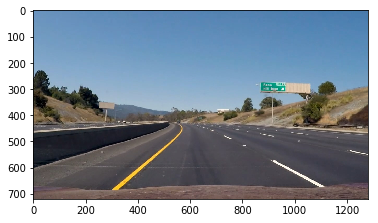

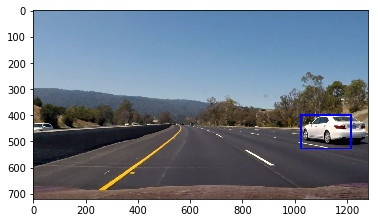

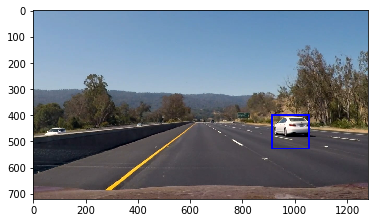

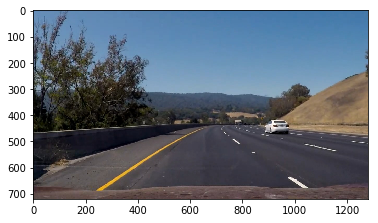

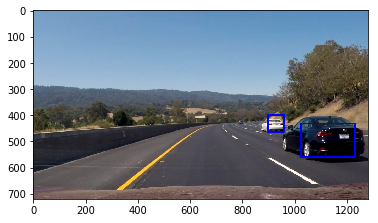

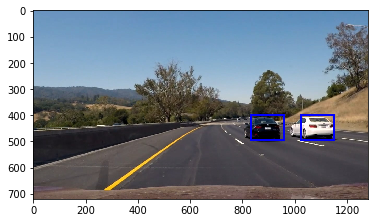

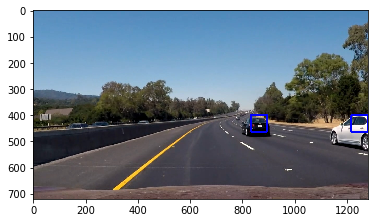

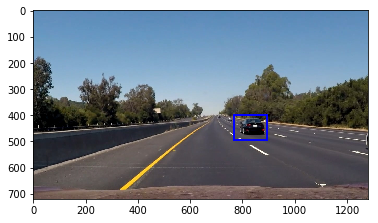

In [8]:
#iii = []
#iii.append(mpimg.imread("learn/non-vehicles/GTI/image100.png"))
#iii.append(mpimg.imread("learn/non-vehicles/GTI/image1310.png"))
#
#
#iii_featvec = extract_features(iii,
#    color_space=feat_extr['color_space'], hist_bins=feat_extr['hist_bins'], spatial_size=feat_extr['spatial_size'], orient=feat_extr['orient'],
#    pix_per_cell=feat_extr['pix_per_cell'], cell_per_block=feat_extr['cell_per_block'], hog_channel=feat_extr['hog_channel'],
#    spatial_feat=feat_extr['spatial_feat'], hist_feat=feat_extr['hist_feat'], hist_color_space=feat_extr['hist_color_space'], hist_color_chn=feat_extr['hist_color_chn'],
#    hog_feat=feat_extr['hog_feat'])
#
#plt.figure()
#plt.plot(img_featvec[0])
#plt.figure()
#plt.plot(img_featvec[1])
#
#X1 = feat_scaler.transform(np.array(iii_featvec, dtype=np.float64))
#pred = clf.predict(X1)
#print (pred)
#print (y_test)


for fname in image_fnames:
    #print (fname)
    img = mpimg.imread(fname)
    lab_img = find_cars_1(img)
    
#for fname in image_fnames:
#    img = cv2.imread(fname) #.astype(np.float32)
#    ##### in mpimg !!!!!!! JPG 0-255, PNG 0-1
#    #break
#    
#    subimgs = get_img_parts(img, windows)
#    #print(subimgs[0][0][0])
#    
#    img_featvec = extract_features(subimgs,
#        color_space=feat_extr['color_space'], hist_bins=feat_extr['hist_bins'], spatial_size=feat_extr['spatial_size'], orient=feat_extr['orient'],
#        pix_per_cell=feat_extr['pix_per_cell'], cell_per_block=feat_extr['cell_per_block'], hog_channel=feat_extr['hog_channel'],
#        spatial_feat=feat_extr['spatial_feat'], hist_feat=feat_extr['hist_feat'], hist_color_space=feat_extr['hist_color_space'], hist_color_chn=feat_extr['hist_color_chn'],
#        hog_feat=feat_extr['hog_feat'])
#
#    
#    #print (X_train.shape) #(1694, 1553)
#    #print (len(img_featvec[2]))
#    #plt.imshow(cv2.resize(subimgs[140], (64, 64)))
#    
#    X = None
#    if enable_norm:
#        X = feat_scaler.transform(img_featvec)
#    else:
#        X = img_featvec    
#
#    #plt.plot(X[0])
#    y_pred = clf.predict(X)
#    #print (pred)
#    
#    #print (np.nonzero(y_pred))
#    bboxes = windows[np.nonzero(y_pred)]
#    #print (bboxes)
#    #img = draw_boxes(img, bboxes)
#    #plt.figure()
#    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.figure()
    plt.imshow(lab_img)
    
plt.show()

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

boxmover = BoxMover()
t_from = 10
t_till = 20

#vidoe_output = 'project_video_out_' + str(t_from) + "-" + str(t_till) + '.mp4'
vidoe_output = 'project_video5_out_2.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip('project_video.mp4') #.subclip(t_from,t_till)
clip1_out = clip1.fl_image(boxmover.processImage)
%time clip1_out.write_videofile(vidoe_output, audio=False)

[MoviePy] >>>> Building video project_video5_out_2.mp4
[MoviePy] Writing video project_video5_out_2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [10:24<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video5_out_2.mp4 

Wall time: 10min 26s
